# PROJECT: Airbnb -  Marketing Analytics



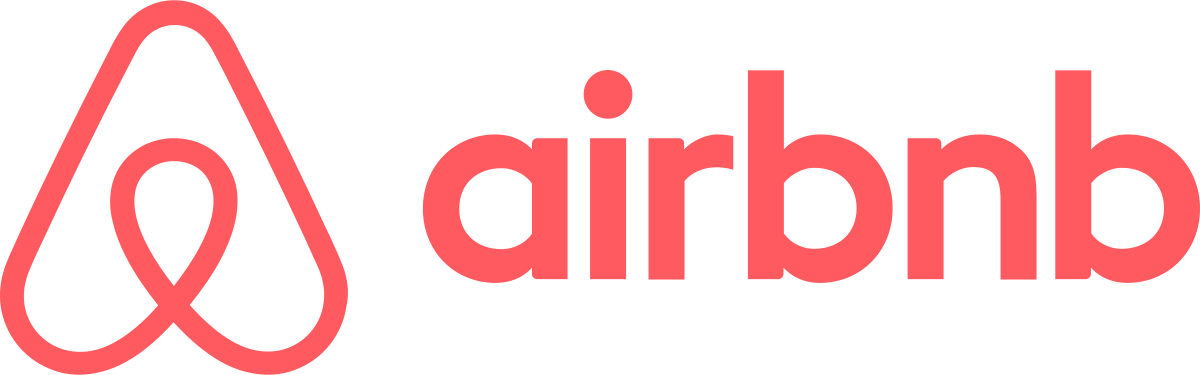

In [1]:
import base64, io, IPython
from PIL import Image as PILImage

image2 = PILImage.open("airbnb.png")
output2 = io.BytesIO()
image2.save(output2, format='PNG')
encoded_string2 = base64.b64encode(output2.getvalue()).decode()
html2 = '<img src="data:image/png;base64,{}"/>'.format(encoded_string2)
IPython.display.HTML(html2)

# Problem Definition

This study is prepared for the "Marketing Analytics" course. The dataset is from a Kaggle Competition named "Airbnb New User Booking". The link for the competititon and dataset as follows: [AirbnbNewUserBooking](https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data).

In the scope of this project, the challenge is to answer below topics;

**1- Identifying different customer segments with Clustering**. 

**2- Predict whether a new user will make a booking using Logistic Regression**


According to the data description, All the users in this dataset are from the USA. Data consists of a list of users along with their demographics, web session records, and some summary statistics.

The original competition is to predict the next booking destination for a given customer. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'.'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, there are new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

# Data Description

The data source are described as follows

**File descriptions**
**train_users.csv - the training set of users**
**test_users.csv - the test set of users**

* id: user id

* date_account_created: the date of account creation

* timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

* date_first_booking: date of first booking

* gender

* age

* signup_method

* signup_flow: the page a user came to signup up from

* language: international language preference

* affiliate_channel: what kind of paid marketing

* affiliate_provider: where the marketing is e.g. google, craigslist, other

* first_affiliate_tracked: whats the first marketing the user interacted with before the signing up

* signup_app

* first_device_type

* first_browser

* country_destination: this is the target variable you are to predict

**sessions.csv - web sessions log for users**
* user_id: to be joined with the column 'id' in users table
* action
* action_type
* action_detail
* device_type
* secs_elapsed

**countries.csv - summary statistics of destination countries in this dataset and their locations**
**age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination**
**sample_submission.csv - correct format for submitting your predictions**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

### User

In [3]:
#Import the user data
df_train = pd.read_csv('airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')

In [4]:
print(f"The user data has {df_train.shape[0]} samples and {df_train.shape[1]} features")

The user data has 213451 samples and 16 features


In [5]:
#show 2 samples from users data
df_train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [6]:
## all user data samples are unique
len(np.unique(df_train.id))

213451

In [7]:
df_train.duplicated().sum()

0

In [8]:
#show user data info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

1. **date_first_booking** and **first_affiliate_tracked**  have null values
2. timestamp_first_active,age, signup_flow are numerical, other features are object

In [9]:
df_train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


### Session

In [10]:
df_sessions = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv.zip')

In [11]:
df_sessions.shape

(10567737, 6)

In [12]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [13]:
df_sessions.action.value_counts()[0:10]

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
Name: action, dtype: int64

In [14]:
#group by user and find the number of activities and total time (in seconds) in website for each user
session_summary = df_sessions.groupby("user_id")["secs_elapsed"].agg({"count","sum"}).rename(columns = {"count":"action_count","sum":"action_duration"}).reset_index()

In [15]:
session_summary.head()

,user_id,action_duration,action_count
0,00023iyk9l,867896.0,39
1,0010k6l0om,586543.0,62
2,001wyh0pz8,282965.0,89
3,0028jgx1x1,297010.0,30
4,002qnbzfs5,6487080.0,788


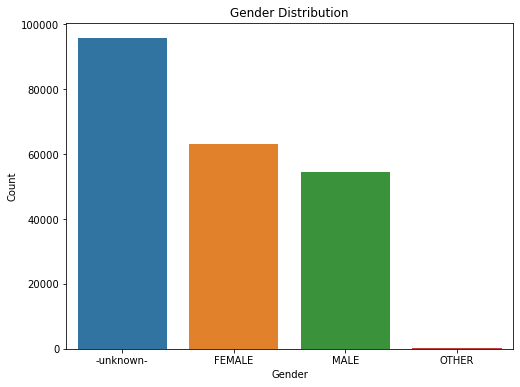

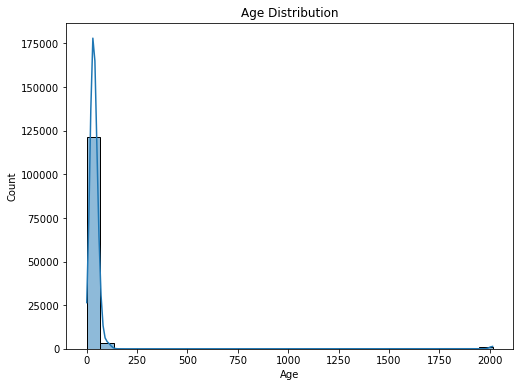

In [16]:
# Plot a bar chart of gender distribution
gender_counts = df_train['gender'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot a histogram of user ages
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='age', bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


From above graphs, it is seen that there are mistakes, missing values in the data, there are users who are 2000 years old or 0 years old. and also most of the customers' gender is unknown.

# Data Preprocessing

In [17]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


#### Age

I will try to cap the outlier values in age, and try to make the values close to a normal distribution

In [18]:
#users above 100 years old (there are 2345)
df_train[df_train.age>100]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212981,l6y2gwgoni,2014-06-30,20140630035617,2014-07-27,-unknown-,105.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,US
213106,1c83n850up,2014-06-30,20140630085741,NaN,MALE,110.0,facebook,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
213182,kh8odg7wnv,2014-06-30,20140630164858,2014-07-04,FEMALE,105.0,basic,0,en,direct,direct,linked,Web,iPhone,Mobile Safari,ES
213199,lyuno62d1q,2014-06-30,20140630171821,2014-07-07,MALE,105.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,US


In [19]:
#%75 percentile + 1.5IQR upper bound
upper_bound = np.percentile(df_train.age.dropna(),75) + 1.5*(np.percentile(df_train.age.dropna(),75) - np.percentile(df_train.age.dropna(),25))

In [20]:
upper_bound

65.5

In [21]:
#%25 percentile - 1.5IQR upper bound
lower_bound = np.percentile(df_train.age.dropna(),25) - 1.5*(np.percentile(df_train.age.dropna(),75) - np.percentile(df_train.age.dropna(),25))

In [22]:
lower_bound

5.5

In [23]:
#cap the upper outliers
df_train.age = df_train.age.apply(lambda x:upper_bound if x>upper_bound else x)

In [24]:
#cap the lower outliers
df_train.age = df_train.age.apply(lambda x:lower_bound if x<lower_bound else x)

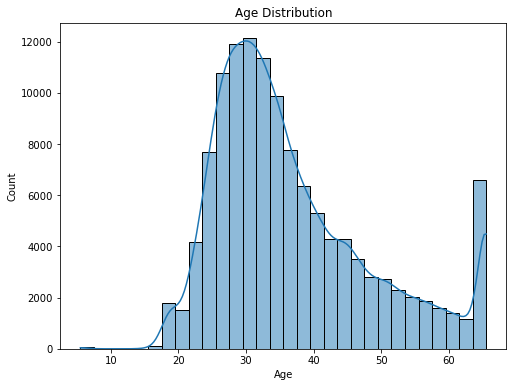

In [25]:
#Now the distribution is more like a normal distribution except the tail on the right
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='age', bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [26]:
df_train.age.describe()

count    125461.000000
mean         36.901882
std          11.681375
min           5.500000
25%          28.000000
50%          34.000000
75%          43.000000
max          65.500000
Name: age, dtype: float64

In [27]:
#missing age values can be important so i will flag them. because missing user info can be indicator of not booking
df_train["is_age_missing"] = df_train.age.apply(lambda x: 1 if pd.isna(x) else 0 )

#### Gender

In [28]:
df_train.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [29]:
#flag unknown gender values
df_train["is_gender_missing"] = df_train.gender.apply(lambda x: 1 if x=="-unknown-" else 0 )

In [30]:
df_train[["is_age_missing","is_gender_missing"]].corr(method="spearman")

,is_age_missing,is_gender_missing
is_age_missing,1.000000,0.754032
is_gender_missing,0.754032,1.000000


It is more likely that if age is missing than gender is also unknown

#### date_account_created

In [31]:
df_train.date_account_created = pd.to_datetime(df_train.date_account_created,format="%Y-%m-%d")

In [32]:
df_train["year_account_created"] = df_train.date_account_created.dt.year
df_train["month_account_created"] = df_train.date_account_created.dt.month
df_train["day_account_created"] = df_train.date_account_created.dt.day
df_train["weekday_account_created"] = df_train.date_account_created.dt.weekday


In [33]:
#since the data was updated this date, 05.12.2015 will be considered as today
today = pd.to_datetime("2015-12-5",format="%Y-%m-%d")

In [34]:
#there are no values that date_account_created bigger than today
df_train[df_train.date_account_created >today]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,is_age_missing,is_gender_missing,year_account_created,month_account_created,day_account_created,weekday_account_created


In [35]:
#calculate how many years do the user with us as "tenure feature"
diff = abs(today-df_train.date_account_created).dt.days.astype('int16')/365
diff

0         5.441096
1         4.534247
2         5.189041
3         4.002740
4         5.227397
            ...   
213446    1.432877
213447    1.432877
213448    1.432877
213449    1.432877
213450    1.432877
Name: date_account_created, Length: 213451, dtype: float64

In [36]:
df_train["tenure"] = diff

<AxesSubplot:>

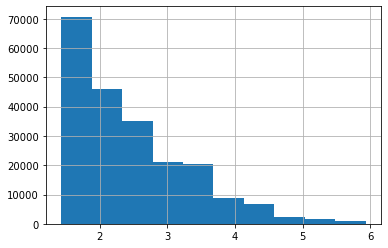

In [37]:
df_train.tenure.hist()

#### first_active_date

In [38]:
df_train["first_active_date"] = [pd.to_datetime(str(timestamp), format="%Y%m%d%H%M%S") for timestamp in df_train.timestamp_first_active]

In [39]:
df_train["year_first_active_date"] = df_train.first_active_date.dt.year
df_train["month_first_active_date"] = df_train.first_active_date.dt.month
df_train["day_first_active_date"] = df_train.first_active_date.dt.day
df_train["weekday_first_active_date"] = df_train.first_active_date.dt.weekday

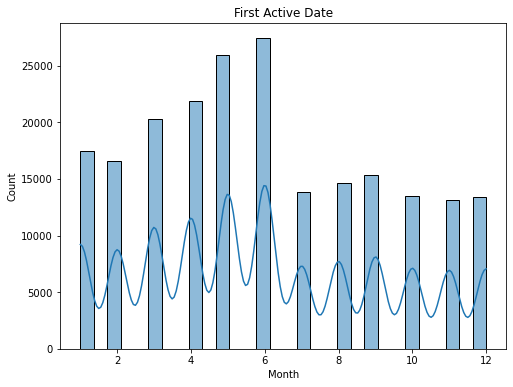

In [40]:

plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='month_first_active_date', bins=30, kde=True)
plt.title('First Active Date')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

People first active date month is mostly June, which can be understandable as people mostly plan their holidays at this month.


Create an artificial variable as **is_booked** by date_first_booking. If date_first_booking is null then the user has never booked so flag it as 0 otherwise flag it as 1

In [41]:
df_train["is_booked"] = df_train.date_first_booking.apply(lambda x: 0 if pd.isna(x) else 1 )

In [42]:
df_train.date_first_booking = pd.to_datetime(df_train.date_first_booking,format="%Y-%m-%d")

#### Categorical Features

In [43]:
[df_train[x].value_counts() for x in df_train.drop("id",axis=1).select_dtypes("object").columns]

[-unknown-    95688
 FEMALE       63041
 MALE         54440
 OTHER          282
 Name: gender, dtype: int64,
 basic       152897
 facebook     60008
 google         546
 Name: signup_method, dtype: int64,
 en    206314
 zh      1632
 fr      1172
 es       915
 ko       747
 de       732
 it       514
 ru       389
 pt       240
 ja       225
 sv       122
 nl        97
 tr        64
 da        58
 pl        54
 cs        32
 no        30
 el        24
 th        24
 id        22
 hu        18
 fi        14
 ca         5
 is         5
 hr         2
 Name: language, dtype: int64,
 direct           137727
 sem-brand         26045
 sem-non-brand     18844
 other              8961
 seo                8663
 api                8167
 content            3948
 remarketing        1096
 Name: affiliate_channel, dtype: int64,
 direct                 137426
 google                  51693
 other                   12549
 craigslist               3471
 bing                     2328
 facebook          

#### browser

In [44]:
df_train["is_browser_unknown"] = df_train.first_browser.apply(lambda x: 1 if x=="-unknown-" else 0)

In [45]:
#Convert browser values as their rates, since there so many different browsers, i will evaluate them with their usage rates but not names
browser_map = df_train.first_browser.value_counts(normalize=True)

In [46]:
browser_map

Chrome                  0.299108
Safari                  0.211613
Firefox                 0.157671
-unknown-               0.127739
IE                      0.098702
Mobile Safari           0.090297
Chrome Mobile           0.005950
Android Browser         0.003987
AOL Explorer            0.001148
Opera                   0.000881
Silk                    0.000581
Chromium                0.000342
BlackBerry Browser      0.000248
Maxthon                 0.000216
IE Mobile               0.000169
Apple Mail              0.000169
Sogou Explorer          0.000155
Mobile Firefox          0.000141
SiteKiosk               0.000112
RockMelt                0.000112
Iron                    0.000080
IceWeasel               0.000061
Pale Moon               0.000056
SeaMonkey               0.000052
CometBird               0.000052
Yandex.Browser          0.000052
Camino                  0.000042
TenFourFox              0.000037
CoolNovo                0.000028
wOSBrowser              0.000028
Avant Brow

In [47]:
df_train["first_browser_rates"] = df_train.first_browser.map(browser_map)

#### language

Most of the users use the website in english, so i will convert this feature as **eng** and **not eng** with is_lang_eng feature

In [48]:
df_train.groupby("language")["is_booked"].agg({"mean","count"}).sort_values(by="count",ascending=False)

,mean,count
language,,
en,0.420059,206314
zh,0.319240,1632
fr,0.340444,1172
es,0.300546,915
ko,0.322624,747
de,0.368852,732
it,0.202335,514
ru,0.282776,389
pt,0.258333,240


In [49]:
df_train["is_lang_eng"] = df_train.language.apply(lambda x: 1 if x=="en" else 0)

#### affiliate_provider

Most of the user reach the AirBnB directly, and secondly with google. Since there are so many different values, like browsers i will convert this feature with rates not actual values.

<AxesSubplot:xlabel='affiliate_provider'>

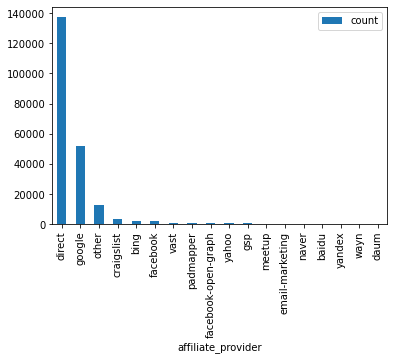

In [50]:
df_train.groupby("affiliate_provider")["is_booked"].agg({"count"}).sort_values(by="count",ascending=False).plot(kind="bar")

In [51]:
df_train["affiliate_provider_converted"] = df_train["affiliate_provider"].map(df_train["affiliate_provider"].value_counts(normalize=True))

In [52]:
df_train.groupby("affiliate_provider")["is_booked"].agg({"count"}).sort_values(by="count",ascending=False)[0:5]

,count
affiliate_provider,
direct,137426
google,51693
other,12549
craigslist,3471
bing,2328


### Combine Session and User

In [53]:
df_merged = pd.merge(df_train,session_summary,left_on="id",right_on="user_id",how="left")

In [54]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id                            213451 non-null  object        
 1   date_account_created          213451 non-null  datetime64[ns]
 2   timestamp_first_active        213451 non-null  int64         
 3   date_first_booking            88908 non-null   datetime64[ns]
 4   gender                        213451 non-null  object        
 5   age                           125461 non-null  float64       
 6   signup_method                 213451 non-null  object        
 7   signup_flow                   213451 non-null  int64         
 8   language                      213451 non-null  object        
 9   affiliate_channel             213451 non-null  object        
 10  affiliate_provider            213451 non-null  object        
 11  first_affilia

In [55]:
dropped_columns = ['user_id','id', 'date_account_created', 'timestamp_first_active','first_browser','date_first_booking','language','affiliate_provider','first_active_date']

In [56]:
#Drop unnecessary features
df_filtered = df_merged.drop(dropped_columns,axis=1)

<AxesSubplot:xlabel='is_booked', ylabel='count'>

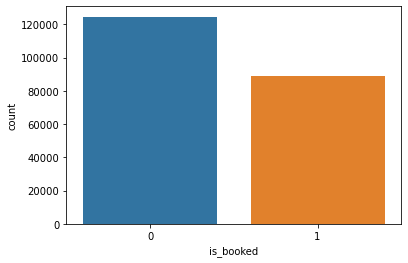

In [57]:
sns.countplot(data=df_merged,x="is_booked")

The number of users who booked is lower than who has never booked, but there is not so much diference.

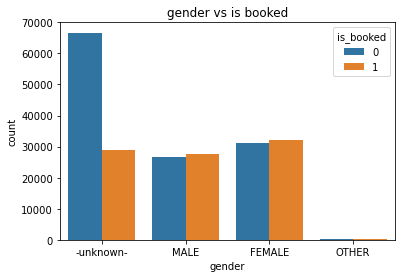

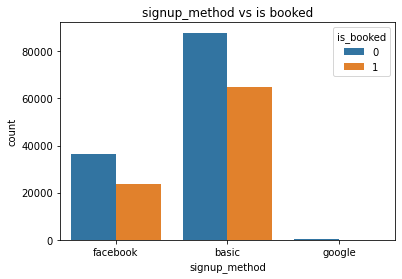

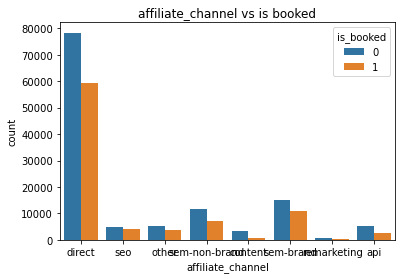

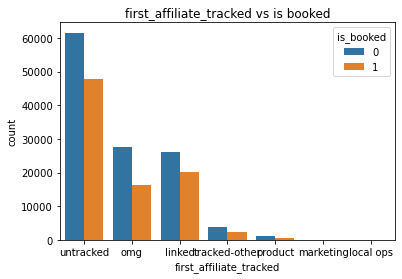

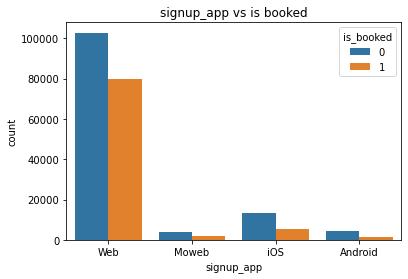

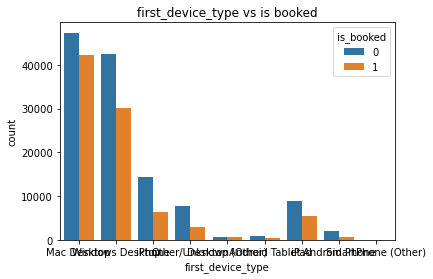

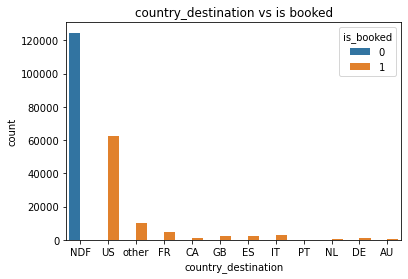

In [58]:
for c in df_filtered.select_dtypes("object").columns:
    sns.countplot(data=df_train,hue="is_booked",x=c)
    plt.title(c + " vs is booked")
    plt.show()
    


<div class="alert alert-success">Using "NDF" (no destination found) is trivial for predicting customers who are booked, because all the customers whose country destination is NDF did not book, as mentioned earlier. Therefore, we will drop "country_destination" variable for logistic regression and also for clustering analysis</div>


In [59]:
df_filtered.drop("country_destination",axis=1,inplace=True)

In [60]:
df_filtered.age.fillna(df_filtered.age.median(),inplace=True)

In [61]:
df_dummied = pd.get_dummies(df_filtered)

In [62]:
df_dummied.columns

Index(['age', 'signup_flow', 'is_age_missing', 'is_gender_missing',
       'year_account_created', 'month_account_created', 'day_account_created',
       'weekday_account_created', 'tenure', 'year_first_active_date',
       'month_first_active_date', 'day_first_active_date',
       'weekday_first_active_date', 'is_booked', 'is_browser_unknown',
       'first_browser_rates', 'is_lang_eng', 'affiliate_provider_converted',
       'action_duration', 'action_count', 'gender_-unknown-', 'gender_FEMALE',
       'gender_MALE', 'gender_OTHER', 'signup_method_basic',
       'signup_method_facebook', 'signup_method_google',
       'affiliate_channel_api', 'affiliate_channel_content',
       'affiliate_channel_direct', 'affiliate_channel_other',
       'affiliate_channel_remarketing', 'affiliate_channel_sem-brand',
       'affiliate_channel_sem-non-brand', 'affiliate_channel_seo',
       'first_affiliate_tracked_linked', 'first_affiliate_tracked_local ops',
       'first_affiliate_tracked_marketin

In [63]:
df_dummied.isna().sum()

age                                           0
signup_flow                                   0
is_age_missing                                0
is_gender_missing                             0
year_account_created                          0
month_account_created                         0
day_account_created                           0
weekday_account_created                       0
tenure                                        0
year_first_active_date                        0
month_first_active_date                       0
day_first_active_date                         0
weekday_first_active_date                     0
is_booked                                     0
is_browser_unknown                            0
first_browser_rates                           0
is_lang_eng                                   0
affiliate_provider_converted                  0
action_duration                          139636
action_count                             139636
gender_-unknown-                        

In [64]:
df_dummied.fillna(0,inplace=True)

## Feature Correlations

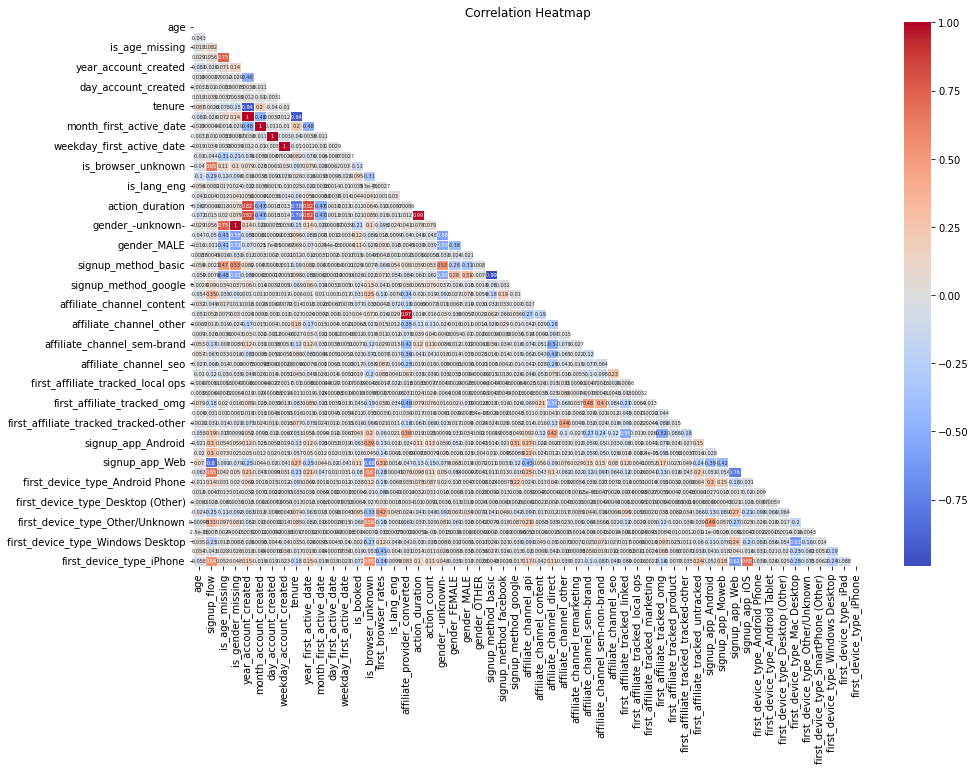

In [65]:
# Calculate the correlation matrix
corr_matrix = df_dummied.corr(method="spearman")

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Create the correlation heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5, annot_kws={"fontsize": 5}, ax=ax)

# Add a title
ax.set_title('Correlation Heatmap')

# Show the plot
plt.show()


In [66]:
corr_matrix["is_booked"].sort_values(ascending=False)[0:3]

is_booked        1.000000
gender_FEMALE    0.119463
gender_MALE      0.109997
Name: is_booked, dtype: float64

In [67]:
corr_matrix["is_booked"].sort_values(ascending=True)[0:3]

is_age_missing      -0.314193
is_gender_missing   -0.207113
gender_-unknown-    -0.207113
Name: is_booked, dtype: float64


<div class="alert alert-success">The most correlated values with is_booked is is_age_missing and is_gender_missing, so missing values can be indicatior of not booking</div>

## Split the Data and Scale

In [68]:
scaler = MinMaxScaler()
y = df_dummied.is_booked
X = df_dummied.drop(["is_booked"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=0,test_size=0.2)
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

# Marketing Methodologies

# 1. Segmentation with Clustering
## Identify the customer segments

In [69]:
!pip install yellowbrick

In [70]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

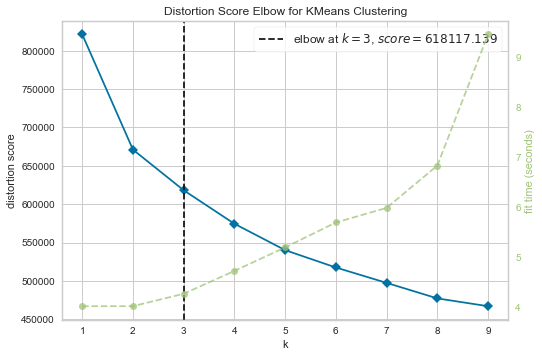

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
# Instantiate the KMeans model
model = KMeans()

# Instantiate the KElbowVisualizer with the KMeans model
visualizer = KElbowVisualizer(model, k=(1, 10))

# Fit the data to the visualizer
visualizer.fit(X_train_scaled)

# Visualize the elbow curve
visualizer.show()

From elbow method, k is determined as 3

In [72]:
kmeans = KMeans(3)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=3)

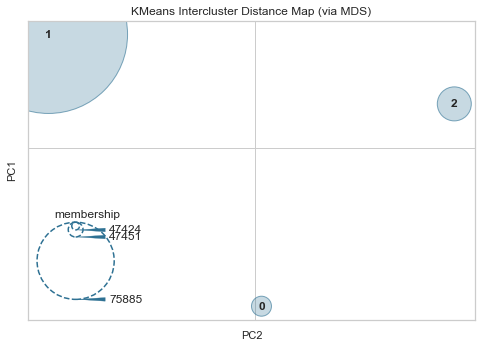

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [73]:
visualizer = InterclusterDistance(kmeans)

# Fit the data to the visualizer
visualizer.fit(X_train_scaled)

# Display the visualization
visualizer.show()

In [74]:
data_copy = pd.DataFrame(scaler.inverse_transform(X_train_scaled.copy()),columns=X_train.columns)

In [75]:
data_copy.head()

,age,signup_flow,is_age_missing,is_gender_missing,year_account_created,month_account_created,day_account_created,weekday_account_created,tenure,year_first_active_date,...,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone
0,40.0,0.0,0.0,0.0,2013.0,11.0,28.0,3.0,2.019178,2013.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,34.0,0.0,1.0,1.0,2014.0,3.0,14.0,4.0,1.728767,2014.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,34.0,0.0,1.0,1.0,2014.0,4.0,4.0,4.0,1.671233,2014.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,25.0,0.0,0.0,0.0,2014.0,5.0,23.0,4.0,1.536986,2014.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,34.0,0.0,1.0,1.0,2013.0,5.0,25.0,5.0,2.531507,2013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [76]:
data_copy["labels"] = kmeans.predict(X_train_scaled)

Identified segments of customers are as follows

# Cluster 0: Young&New& MostActive & IphoneUser

In [77]:
data_copy.query("labels==0").agg("mean").sort_values(ascending=False)[0:20]

action_duration                      624034.536205
year_account_created                   2012.906967
year_first_active_date                 2012.905428
age                                      37.227427
action_count                             28.044893
day_account_created                      15.856360
day_first_active_date                    15.854989
month_first_active_date                   6.143408
month_account_created                     6.143387
weekday_account_created                   2.743168
weekday_first_active_date                 2.742810
tenure                                    2.552416
signup_flow                               2.435961
signup_method_basic                       0.999937
is_lang_eng                               0.974317
signup_app_Web                            0.908211
affiliate_channel_direct                  0.668501
gender_FEMALE                             0.555352
first_affiliate_tracked_untracked         0.513453
affiliate_provider_converted   

# Cluster 1: WebUser & Full_Info 

In [78]:
data_copy.query("labels==1").agg("mean").sort_values(ascending=False)[0:20]

action_duration              539364.628807
year_account_created           2013.164644
year_first_active_date         2013.164473
age                              34.669612
action_count                     26.840166
day_first_active_date            15.895856
day_account_created              15.894683
month_account_created             5.917863
month_first_active_date           5.917783
signup_flow                       4.204968
weekday_first_active_date         2.771404
weekday_account_created           2.771325
tenure                            2.313364
gender_-unknown-                  1.000000
labels                            1.000000
is_gender_missing                 1.000000
signup_method_basic               0.989260
is_lang_eng                       0.971918
is_age_missing                    0.831139
signup_app_Web                    0.824168
dtype: float64

# Cluster 2: Web User & Missing Info 

In [79]:
data_copy.query("labels==2").agg("mean").sort_values(ascending=False)[0:20]

action_duration                      399340.286611
year_account_created                   2012.914986
year_first_active_date                 2012.914480
age                                      35.895029
action_count                             21.261765
day_account_created                      15.868180
day_first_active_date                    15.867484
month_account_created                     6.075151
month_first_active_date                   6.074645
weekday_first_active_date                 2.761143
weekday_account_created                   2.761122
signup_flow                               2.573876
tenure                                    2.550011
labels                                    2.000000
signup_method_facebook                    0.998377
is_lang_eng                               0.950665
signup_app_Web                            0.856273
affiliate_channel_direct                  0.595288
first_affiliate_tracked_untracked         0.507155
gender_FEMALE                  

# 2. Classification with Logistic Regression
## Which customers will book?

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
model = LogisticRegression(random_state=42)

In [82]:
model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=42)

In [83]:
def plot_roc_curve(model, X_test_scaled,y_test):
    # predict probabilities
    lr_probs_ = model.predict_proba(X_test_scaled)
    ns_probs = [0 for _ in range(len(y_test))]
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs_[:,1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.738


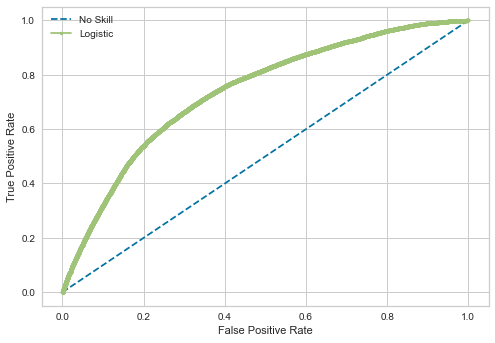

In [84]:
plot_roc_curve(model, X_test_scaled,y_test)


<div class="alert alert-warning">AUC=0.738 which is pretty good, our model did a good job for predicting the customers who will book</div

In [85]:
# Get the coefficients or weights of the features
feature_weights = model.coef_[0]

In [86]:
pd.DataFrame(feature_weights,  X.columns).sort_values(by=0,ascending=False)

,0
action_duration,4.452943
affiliate_channel_api,0.703902
signup_flow,0.481155
signup_app_Web,0.466030
tenure,0.464943
signup_method_google,0.382403
is_lang_eng,0.373911
signup_method_basic,0.332337
affiliate_provider_converted,0.288188
first_browser_rates,0.245540


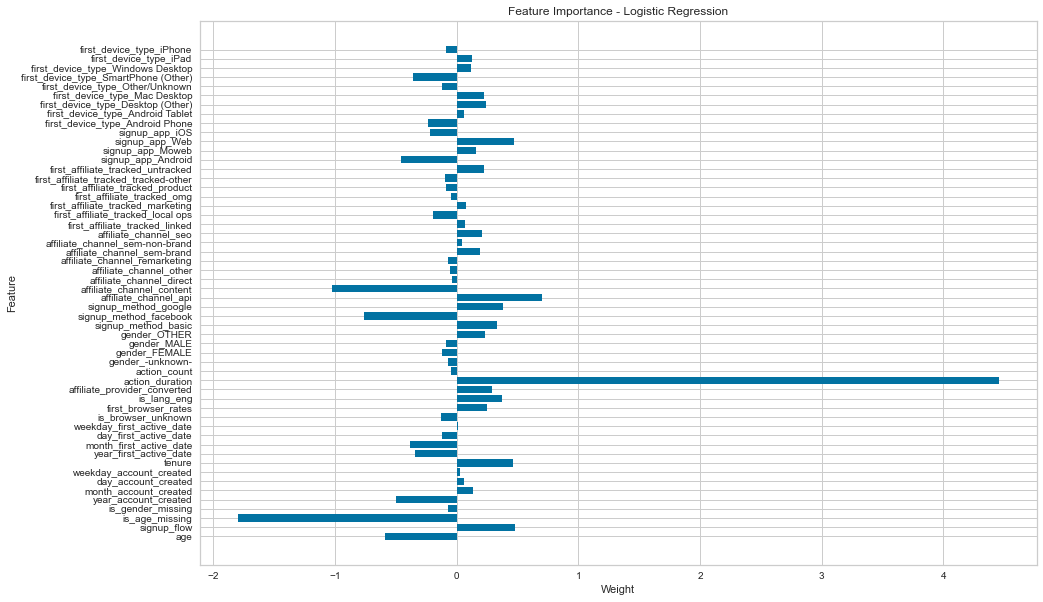

In [87]:

# Create a horizontal bar plot to visualize feature weights
plt.figure(figsize=(15, 10))
plt.barh(range(len(feature_weights)), feature_weights, align='center')
plt.yticks(range(len(feature_weights)), X.columns)
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.show()

From above analysis, it is seen that most important features effecting users to book or not are as follows;


* **is_age_missing**	-1.801702
* **affiliate_channel_content**	-1.026368
* **signup_method_facebook**	-0.763349
* **age**	-0.587321
* **signup_flow**	0.481155
* **affiliate_channel_api**	0.703902
* **action_duration**	4.452943



Let's create a model with that features;

In [88]:
best_features = ["is_age_missing",
"affiliate_channel_content",
"signup_method_facebook",
"age",
"signup_flow",
"affiliate_channel_api",
"action_duration"]

In [89]:
model = LogisticRegression(random_state=42)

In [90]:
model.fit(X_train_scaled[best_features],y_train)

LogisticRegression(random_state=42)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.718


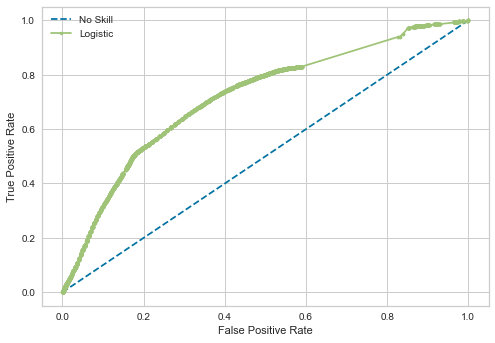

In [91]:
plot_roc_curve(model, X_test_scaled[best_features],y_test)

Model AUC score is lower, but this is one prediction, so we can do cross validation to be more sure about the results being better or worse.